CS 28150 Extra Credit 2

Zack Wang

We have two problems: Dampened Oscillator and Moon. For both, we can reuse much of HW 4's code, with our IVP solver. The only difference is that our vector U will be much larger, keeping track of both points' positions and first derivatives. This also means our incrementation with U' will be more complicated.

In [118]:
import numpy as np
import matplotlib.pyplot as plt
import math
plt.style.use('seaborn-whitegrid')

class simTime:
    time = 0
    dt = 1
    tol = .1
    agrow = 1.25
    ashrink = .8
    dtmin = .2
    dtmax = 2
    endTime = 5
    stepsSinceRejection = 0
    stepsRejected = 0
    stepsAccepted = 0
    def __init__(self, t, tol, agrow, ashrink, dtmin, dtmax, endt):
        self.time = t
        self.tol = tol
        self.agrow = agrow
        self.ashrink = ashrink
        self.dtmin = dtmin
        self.dt = dtmin
        self.dtmax = dtmax
        self.endTime = endt

    def successStep(self):
        self.time += self.dt
        self.stepsSinceRejection += 1
        if self.stepsSinceRejection > 3:
            potential = self.agrow * self.dt
            if potential > self.dtmax:
                self.dt = self.dtmax
            elif potential < self.dtmin:
                self.dt = self.dtmin
            else:
                self.dt = potential
            #need something here, set dt to end up exactly at self.edntime if necessary
            if (self.time + self.dt) > self.endTime:
                self.dt = self.endTime - self.time
        self.stepsAccepted += 1

    def cautiousStep(self):
        self.time += self.dt
        self.stepsSinceRejection += 1
        potential = self.ashrink * self.dt
        if potential > self.dtmax:
            self.dt = self.dtmax
        elif potential < self.dtmin:
            self.dt = self.dtmin
        else:
            self.dt = potential
        if (self.time + self.dt) > self.endTime:
                self.dt = self.endTime - self.time
        self.stepsAccepted += 1

    def takeIt(self):
        self.time += self.dt
        self.stepsAccepted += 1

    def failedStep(self):
        self.dt /= 2
        self.stepsSinceRejection = 0
        self.stepsRejected += 1

        


def step1(y, t, dt, f):
    #copmutes straightforward euler, f is the change of value
    w = np.add(y, (dt * f(t, y)) )
    return w

def step2(y, t, dt, f):
    initalGuess = step1(y, t, dt, f)
    wHalfway = step1(y, t, dt/2, f)
    wRest = step1(wHalfway, t + (dt / 2), dt/2, f)
    ddy = wRest - initalGuess
    w = wRest + ddy
    return w

def step3(y, t, dt, f):
    initalGuess = step2(y, t, dt, f)
    wHalfway = step2(y, t, dt/2, f)
    wRest = step2(wHalfway, t + (dt / 2), dt/2, f)
    ddy = wRest - initalGuess
    w = wRest + (ddy/3)
    return w, np.linalg.norm(ddy)

def chart(startt, starty, end, foo, st):
    #traverses the whole thing
    xs = []
    ys = []
    t = startt
    y = starty
    ys.append(y)
    xs.append(t)
    while (st.time < end):
        #print(st.time, st.dt)
        testStep, err = step3(y, st.time, st.dt, foo) 
        if err < st.tol:
            #print(err)
            if err > (.75 * st.tol):
                #print("close enough")
                st.cautiousStep()
                ys.append(testStep)
                xs.append(st.time)
                y = testStep
            else:
                st.successStep()
                ys.append(testStep)
                xs.append(st.time)
                y = testStep
        
        else:
            if st.dt <= st.dtmin:
                st.takeIt()
                ys.append(testStep)
                xs.append(st.time)
                y = testStep
            else:
                st.failedStep()
    return xs, ys, st
    

Problem 1: Two Points

For the orbit of a comet, we have to first devise a variable U and function f that encapsulate the data we want in a first-derivative systems of equations. We can let U be a 8x1 vector that represents our current location at the time. U = (p0x, p0y, p0x', p0y', p1x, p1y, p1x', p1y'). We then define a f(t, U) that considers our current U, and returns a new U. This f(t, U) will update our state using the same logic as the original Euler method.

To find this f(t, U) we use U substitution. This gives us U' = (p0x', p0y', -force component of x, -force component of y, p1x', p1y', force component of x, force component of y,), which we will plug in as our foo function. The force component is a simple calculation that requires us calculating the displacement vector between the two, and then multiplying it by a calculated fm. Below we have three graphs: one with no initial velocities (to show proof of concept with a simple spring), one with initial velocities in the y direction, and one with more complex initial velocities. 

For our first graph with no initial velocities, we see what we expect: the two points move directly towards each other, then osciallate at a fixed distance. 

For our real solution, we see the two points reach a sort of orbit, where they maintain a set distance from each other, while still maintaining a rotational momentum. This can be seen with the distance graph: after a few sinusoidal waves, the distances approach a set distance of around .2

For the more complicated solution, we see a very neat spiral pattern, kind of like a binary star system. Interestingly enough, the distance graph is virtually the same, as after the first few cycles the two points maintain a set distance from one another.

Text(0.5, 1.0, 'Trajectories, Light Color is Start, NO Initial Vel')

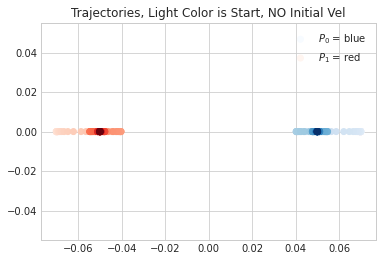

In [119]:
def force1(t, y):
    dx = y[4] - y[0]
    dy = y[5] - y[1]
    dist = (((y[4] - y[0]) ** 2) + ((y[5] - y[1]) ** 2)) ** .5
    springConst = 10
    rest = .1
    dampConst = 1
    dxprime = y[6] - y[2]
    dyprime = y[7] - y[3]
    deriv = ((dx * dxprime) + (dy * dyprime)) / dist
    force = springConst * (rest - dist) - (dampConst * deriv)
    forceVec = force * (dx/dist), force * (dy/dist)
    res = [y[2], y[3], -forceVec[0], -forceVec[1], y[6], y[7], forceVec[0], forceVec[1]] 
    return np.array(res)

springTime = simTime(0, 10 ** -4, 1.25, .8, .001, 1, 10)
startpos = np.array([0.07, 0, 0, 0, -.07, 0, 0, 0])
ot, oy, ost = chart(0, startpos, 10, force1, springTime)

xpoint = []
x2 = []
y2 = []
ypoint = []
for i in oy:
    xpoint.append(i[0])
    ypoint.append(i[1])
    x2.append(i[4])
    y2.append(i[5])
col = np.arange(len(xpoint))

fig = plt.figure()
ax = plt.axes()
plt.scatter(xpoint, ypoint, c = col, cmap='Blues', label = "$P_0$ = blue")
plt.scatter(x2, y2, c = col, cmap='Reds', label = "$P_1$ = red")
plt.legend()
plt.title("Trajectories, Light Color is Start, NO Initial Vel")

Text(0.5, 1.0, 'Trajectories, Light Color is Start, Regular Initial Vel')

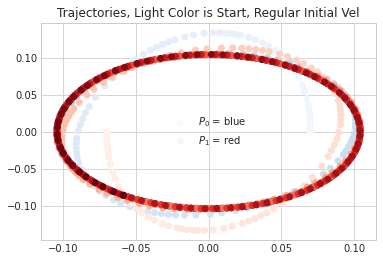

In [120]:
springTime = simTime(0, 10 ** -4, 1.25, .8, .001, 1.5, 10)
startpos = np.array([0.07, 0, 0, .5, -.07, 0, 0, -.5])
ot, oy, ost = chart(0, startpos, 10, force1, springTime)

xpoint = []
x2 = []
y2 = []
ypoint = []
d = []
for i in oy:
    xpoint.append(i[0])
    ypoint.append(i[1])
    x2.append(i[4])
    y2.append(i[5])
    dist = (((i[4] - i[0]) ** 2) + ((i[5] - i[1]) ** 2)) ** .5
    d.append(dist)
col = np.arange(len(xpoint))

fig = plt.figure()
ax = plt.axes()
plt.scatter(xpoint, ypoint, c = col, cmap='Blues', label = "$P_0$ = blue")
plt.scatter(x2, y2, c = col, cmap='Reds', label = "$P_1$ = red")
plt.legend()
plt.title("Trajectories, Light Color is Start, Regular Initial Vel")

Text(0.5, 1.0, 'Distance vs Time, Regular Initial Vel')

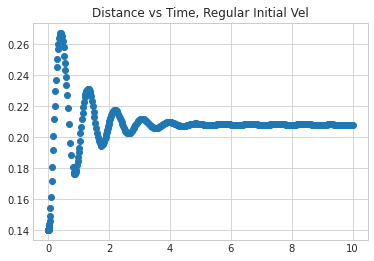

In [121]:
fig = plt.figure()
ax = plt.axes()

plt.scatter(ot, d)
plt.title("Distance vs Time, Regular Initial Vel")

Text(0.5, 1.0, 'Trajectories, Light Color is Start, New Initial Vel')

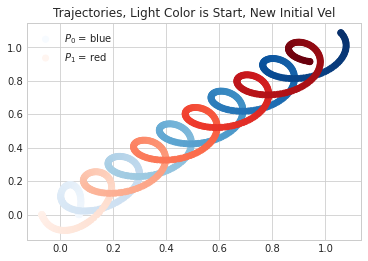

In [122]:
springTime = simTime(0, 10 ** -4, 1.25, .8, .001, 1.5, 10)
startpos = np.array([0.07, 0, .1, .6, -.07, 0, .1, -.4])
ot2, oy2, ost2 = chart(0, startpos, 10, force1, springTime)

xpoint2 = []
x2 = []
y2 = []
ypoint2 = []
d2 = []
for i in oy2:
    xpoint2.append(i[0])
    ypoint2.append(i[1])
    x2.append(i[4])
    y2.append(i[5])
    dist2 = (((i[4] - i[0]) ** 2) + ((i[5] - i[1]) ** 2)) ** .5
    d2.append(dist2)
col = np.arange(len(xpoint2))

fig = plt.figure()
ax = plt.axes()
plt.scatter(xpoint2, ypoint2, c = col, cmap='Blues', label = "$P_0$ = blue")
plt.scatter(x2, y2, c = col, cmap='Reds', label = "$P_1$ = red")
plt.legend()
plt.title("Trajectories, Light Color is Start, New Initial Vel")

Text(0.5, 1.0, 'Distance vs Time, New Initial Vel')

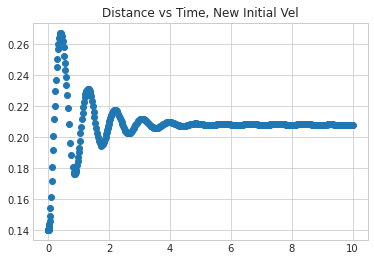

In [123]:
fig = plt.figure()
ax = plt.axes()

plt.scatter(ot2, d2)
plt.title("Distance vs Time, New Initial Vel")

Problem 2: Moon

The additional consideration for this problem is another force, being the gravitational pull towards the origin. We factor this in using vector addition, and get an orbital pattern of the two points about the origin. Differing from the first problem, the two points are basically side-by-side in their orbits, like two runners in track. We can see this effect in the distance and angle graphs. The angle shows that once enough time has passed, the two points maintain a locked-position as time advances. Because of this locked position, we see the distance between the two points to become relatively constant near the end of the time interval. 

Text(0.5, 1.0, 'Trajectories, Light Color is Start, Moon')

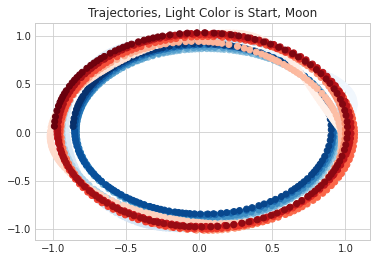

In [124]:
def force2(t, y):
    dx = y[4] - y[0]
    dy = y[5] - y[1]
    p0mag = ((y[0] ** 2) + (y[1] ** 2)) ** .5
    p1mag = ((y[4] ** 2) + (y[5] ** 2)) ** .5
    dist = (((y[4] - y[0]) ** 2) + ((y[5] - y[1]) ** 2)) ** .5
    springConst = 10
    rest = .1
    dampConst = 1
    dxprime = y[6] - y[2]
    dyprime = y[7] - y[3]
    deriv = ((dx * dxprime) + (dy * dyprime)) / dist
    attractForce = (dx/dist, dy/dist) * np.array([(springConst * (rest - dist) - (dampConst * deriv))]) 
    gravP0 = np.array([(1 / (p0mag ** 2))]) * ( -y[0] / p0mag, -y[1]/ p0mag)
    gravP1 = np.array([(1 / (p1mag ** 2))]) * ( -y[4] / p1mag, -y[5]/ p1mag)
    forceOnP0 = -attractForce[0] + gravP0[0], -attractForce[1] + gravP0[1]
    forceOnP1 = attractForce[0] + gravP1[0], attractForce[1] + gravP1[1]
    res = [y[2], y[3], forceOnP0[0], forceOnP0[1], y[6], y[7], forceOnP1[0], forceOnP1[1]] 
    return np.array(res)

moonTime = simTime(0, 10 ** -4, 1.25, .8, .001, 1, 12 * math.pi)
startMoon = np.array([1, 0.05, .4, 1, 1, -.05, -.4, 1])
tmoon, ymoon, stmoon = chart(0, startMoon, 12 * math.pi, force2, moonTime)

p0xmoon = []
p0ymoon = []
p1xmoon = []
p1ymoon = []
dmoon = []
ang = []
for i in ymoon:
    p0xmoon.append(i[0])
    p0ymoon.append(i[1])
    p1xmoon.append(i[4])
    p1ymoon.append(i[5])
    diff = (i[4] - i[0], i[5] - i[1])
    other = np.array([.5]) * (i[4] + i[0], i[5] + i[1])
    magdiff = (((i[4] - i[0]) ** 2) + ((i[5] - i[1]) ** 2)) ** .5
    magother = ((other[0]) ** 2 + (other[1] ** 2)) ** .5
    dmoon.append(magdiff)
    ang.append(math.acos(np.dot(diff, other) / (magdiff * magother)))
col = np.arange(len(p0xmoon))

fig = plt.figure()
ax = plt.axes()
plt.scatter(p0xmoon, p0ymoon, c = col, cmap='Blues', label = "$P_0$ = blue")
plt.scatter(p1xmoon, p1ymoon, c = col, cmap='Reds', label = "$P_1$ = red")
#plt.legend()
plt.title("Trajectories, Light Color is Start, Moon")

Text(0.5, 1.0, 'Distance vs Time, Moon')

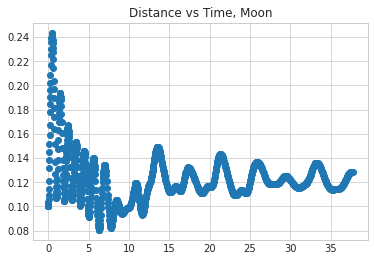

In [125]:
fig = plt.figure()
ax = plt.axes()

plt.scatter(tmoon, dmoon)
plt.title("Distance vs Time, Moon")

Text(0.5, 1.0, 'Angle vs Time, Moon')

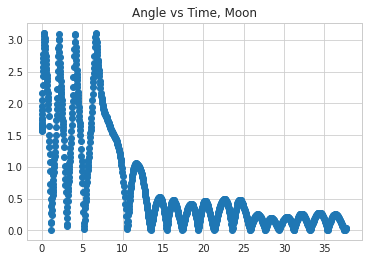

In [126]:
fig = plt.figure()
ax = plt.axes()

plt.scatter(tmoon, ang)
plt.title("Angle vs Time, Moon")